## Let's try RNN

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt


In [2]:
DATA_DIR = "./generated_data"
CSV_NAME = "generated_data_1.csv"

In [3]:
df = pd.read_csv(os.path.join(DATA_DIR, CSV_NAME))
df = df.interpolate() # to prevent nan in model output
df.head()


,noisy motion,kalman prediction,ground truth,motion noise stdev,laser noise stdev,laser range 1,laser range 2,laser range 3,laser range 4,laser range 5,laser range 6
0,-1.155220,3.551487,3.268738,2,0.01,6.463386,6.457985,6.450579,6.449560,6.465331,6.462147
1,-0.344686,3.759194,3.941828,2,0.01,6.305038,6.282087,6.263595,6.265825,6.249935,6.243805
2,-0.265481,4.417085,4.019310,2,0.01,5.602849,5.594613,5.582178,5.580036,5.585974,5.587743
3,0.465647,4.499272,4.404337,2,0.01,5.538476,5.515565,5.505001,5.503956,5.516458,5.535148
4,0.182628,4.881963,4.111349,2,0.01,5.140490,5.114725,5.125316,5.132672,5.123336,5.125902


In [4]:
# df[df.isna().values]

In [5]:
# Define the RNN model
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        if out.isnan().any():
            print("NAN:", out)
        # print(out.shape)
        out = self.fc(out[:, -1, :]) # taking only the last hidden layer output
        if out.isnan().any():
            print("NAN: Second: ", out)
        # print(out.shape)
        return out

In [6]:
# Create some dummy data
seq_len = 3
batch_size = 10
# num_batches = 69
num_batches = (len(df) - seq_len) // (batch_size)
input_size = 9
output_size = 1
num_batches

104

In [7]:
len(df)/batch_size

105.0

In [8]:
labels = np.array(df["ground truth"].to_list())
input_data_df = df[['noisy motion', 'motion noise stdev', 'laser noise stdev', 'laser range 1',
       'laser range 2', 'laser range 3', 'laser range 4', 'laser range 5',
       'laser range 6']].to_numpy()

# input_data = input_data_df[:num_batches * batch_size]
input_data = input_data_df.copy()

# output_data = labels[:num_batches * batch_size]
output_data = labels.copy()



In [9]:
input_data.shape, output_data.shape

((1050, 9), (1050,))

In [10]:
input_data[range(len(input_data) - seq_len)[-1] + seq_len]

array([4.14828569e+02, 2.00000000e+00, 1.00000000e-02, 1.32518971e+00,
       1.33487737e+00, 1.33140516e+00, 1.34016287e+00, 1.32664394e+00,
       1.33908546e+00])

In [11]:
new_input_data = []
new_output_data = []

for i in range(len(input_data) - seq_len):
    new_input_data.append(input_data[i:i+seq_len])
    new_output_data.append(output_data[i + seq_len -1])

new_input_data = np.array(new_input_data[:num_batches* batch_size]) # drop the last batch
new_output_data = np.array(new_output_data[:num_batches* batch_size]) # drop the last batch



In [12]:
# # sanity check
# print(new_input_data[0], new_output_data[0].round(6))
# df.head()

In [19]:
new_input_data.shape == (num_batches* batch_size, seq_len, new_input_data.shape[-1])

True

In [28]:
input_data = torch.from_numpy(np.reshape(new_input_data, (num_batches , batch_size, seq_len, new_input_data.shape[-1]))).type(torch.float32)
output_data = torch.from_numpy(np.reshape(new_output_data, (num_batches , batch_size, -1))).type(torch.float32)

input_data.shape, output_data.shape


(torch.Size([104, 10, 3, 9]), torch.Size([104, 10, 1]))

In [30]:
# dataset = torch.utils.data.TensorDataset(new_input_data, new_input_data)
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [31]:
# dataset[0][0].shape, dataset[0][1].shape



In [32]:
embedding_size = 9
hidden_size = 64
output_size = 1
lr = 0.0001
model = SimpleRNN(embedding_size, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [40]:
# Train the model
loss_cache = []

num_epochs = 1000
for epoch in range(num_epochs):
    for i in range(len(input_data)):
        batch_inputs = input_data[i]
        batch_outputs = output_data[i]
        # break

        optimizer.zero_grad()
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_outputs)
        loss.backward()
        optimizer.step()
    loss_cache.append(loss.item())
    # Print the loss after every epoch
    if epoch %10 ==0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))



Epoch [1/1000], Loss: 0.3971
Epoch [11/1000], Loss: 0.4111
Epoch [21/1000], Loss: 0.3065
Epoch [31/1000], Loss: 0.3343
Epoch [41/1000], Loss: 0.3278
Epoch [51/1000], Loss: 0.3245
Epoch [61/1000], Loss: 0.5909
Epoch [71/1000], Loss: 0.3015
Epoch [81/1000], Loss: 0.4443
Epoch [91/1000], Loss: 0.3482
Epoch [101/1000], Loss: 0.4192
Epoch [111/1000], Loss: 0.2844
Epoch [121/1000], Loss: 0.3213
Epoch [131/1000], Loss: 0.3372
Epoch [141/1000], Loss: 0.4399
Epoch [151/1000], Loss: 0.2759
Epoch [161/1000], Loss: 0.2674
Epoch [171/1000], Loss: 0.4349
Epoch [181/1000], Loss: 0.5053
Epoch [191/1000], Loss: 0.4820
Epoch [201/1000], Loss: 0.4329
Epoch [211/1000], Loss: 0.4212
Epoch [221/1000], Loss: 0.4760
Epoch [231/1000], Loss: 0.7713
Epoch [241/1000], Loss: 0.7379


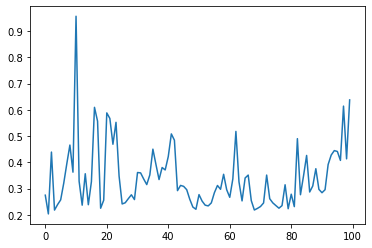

In [ ]:
plt.plot(loss_cache)
